<a href="https://colab.research.google.com/github/nekkantirohit/INFO5731/blob/main/In_class_exercise_04_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**The seventh in-class-exercise (40 points in total, 10/20/2021)**

(1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

#Importing Required Modules

In [ ]:
# Write your code here
!pip install pyLDAvis
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import spacy.cli
spacy.cli.download('en_core_web_sm')
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


#Importing Stopwords module from nltk

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#importing link

In [ ]:

n = [ ]
data = [ ]
p_no = [0,10,20,30,40,50,60,70,80,90]
for i in p_no:
  #calling the link using request module
  p = requests.get('https://www.imdb.com/title/tt6751668/reviews?ref_=tt_urv'+ str (i))
  review = BeautifulSoup(p.content,'html.parser')
  n.append(review.find_all('a',class_='title'))

for j in n:
  for k in range(len(j)):
    data.append(j[k].get_text())



# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#Tokenization and punctuation

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['loved', 'the', 'first', 'but', 'the', 'last', 'might', 'be', 'very', 'tough', 'for', 'some', 'viewers']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
#deining removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
#defining removing bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
#removing trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
#lemmitization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['love', 'first', 'last', 'may', 'tough', 'viewer']]


In [ ]:
# Create a Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create the Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [ ]:
# Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
#printing lda model topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.913*"parasite" + 0.002*"certainly" + 0.002*"underwhelme" + 0.002*"enough" '
  '+ 0.002*"earn" + 0.002*"conventional" + 0.002*"interesting" + '
  '0.002*"picture" + 0.002*"attention" + 0.002*"topic"'),
 (1,
  '0.017*"fragile" + 0.017*"ecosystem" + 0.017*"drama" + 0.017*"aspect" + '
  '0.017*"social" + 0.017*"incredible" + 0.017*"good" + 0.017*"comfort" + '
  '0.017*"intelligent" + 0.017*"entertaining"'),
 (2,
  '0.779*"intruder" + 0.004*"half" + 0.004*"film" + 0.004*"parasite" + '
  '0.004*"probably" + 0.004*"story" + 0.004*"tell" + 0.004*"interesting" + '
  '0.004*"ill" + 0.004*"piece"'),
 (3,
  '0.017*"parasite" + 0.017*"story" + 0.017*"first" + 0.017*"ghost" + '
  '0.017*"last" + 0.017*"viewer" + 0.017*"love" + 0.017*"may" + 0.017*"tough" '
  '+ 0.017*"enough"'),
 (4,
  '0.439*"thoroughly" + 0.439*"entertaining" + 0.002*"story" + 0.002*"thought" '
  '+ 0.002*"enough" + 0.002*"earn" + 0.002*"conventional" + 0.002*"certainly" '
  '+ 0.002*"interesting" + 0.002*"picture"'),
 (

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Computing the Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.3092529026874855

Coherence Score:  0.5006185814919522


In [ ]:
#defining mallet 
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

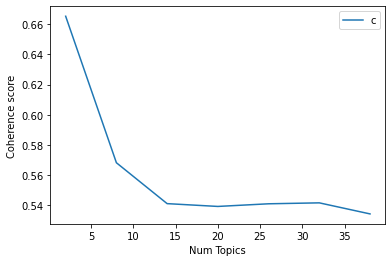

In [ ]:
# Show graph lda model graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
#giving coherence values of num of topics
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6653
Num Topics = 8  has Coherence Value of 0.5682
Num Topics = 14  has Coherence Value of 0.5411
Num Topics = 20  has Coherence Value of 0.5392
Num Topics = 26  has Coherence Value of 0.541
Num Topics = 32  has Coherence Value of 0.5416
Num Topics = 38  has Coherence Value of 0.5342


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.556*"engage" + 0.222*"interesting" + 0.111*"picture" + 0.056*"thought" + '
  '0.056*"piece" + 0.000*"certainly" + 0.000*"enough" + 0.000*"earn" + '
  '0.000*"conventional" + 0.000*"pay"'),
 (1,
  '0.800*"film" + 0.120*"fairly" + 0.080*"funny" + 0.000*"conventional" + '
  '0.000*"picture" + 0.000*"enough" + 0.000*"earn" + 0.000*"interesting" + '
  '0.000*"certainly" + 0.000*"pay"'),
 (2,
  '0.256*"conventional" + 0.256*"ill" + 0.256*"earn" + 0.205*"piece" + '
  '0.026*"interesting" + 0.000*"pay" + 0.000*"topic" + 0.000*"attention" + '
  '0.000*"enough" + 0.000*"tad"'),
 (3,
  '0.435*"half" + 0.435*"intruder" + 0.087*"fairly" + 0.043*"question" + '
  '0.000*"certainly" + 0.000*"tad" + 0.000*"earn" + 0.000*"conventional" + '
  '0.000*"ill" + 0.000*"picture"'),
 (4,
  '0.323*"attention" + 0.323*"pay" + 0.323*"topic" + 0.032*"social" + '
  '0.000*"conventional" + 0.000*"underwhelme" + 0.000*"enough" + 0.000*"earn" '
  '+ 0.000*"interesting" + 0.000*"certainly"'),
 (5,
  '0.323*"or

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.1017,"love, tough, viewer, life, certainly, ill, eno...",I loved the first 90%....but the last might b...
1,1,10.0,0.0686,"work, entertaining, ghost, enough, earn, conve...",Thoroughly entertaining
2,2,0.0,0.0500,"engage, interesting, picture, thought, piece, ...",class warfare
3,3,16.0,0.0673,"totally, question, fairly, certainly, enough, ...",Totally Unique
4,4,19.0,0.0813,"good, entertain, parasite, conventional, ill, ...","Fairly entertaining film, but one of 2019s be..."
5,5,5.0,0.1038,"original, unconventional, overrate, piece, eno...","Original, Unconventional and Overrated"
6,6,15.0,0.0599,"parasite, thought, interesting, totally, earn,...",Parasite
7,7,14.0,0.1141,"aspect, drama, intelligent, social, certainly,...","Engaging as a drama, with an intelligent soci..."
8,8,13.0,0.0823,"story, ghost, picture, enough, earn, conventio...",Ghost Story
9,9,0.0,0.0500,"engage, interesting, picture, thought, piece, ...",Not a leech (?)


In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0500,"engage, interesting, picture, thought, piece, ...",class warfare
1,1.0,0.0751,"film, fairly, funny, conventional, picture, en...","Fairly entertaining film, but one of 2019s be..."
2,2.0,0.1121,"conventional, ill, earn, piece, interesting, p...",Parasite was an interesting enough piece of w...
3,3.0,0.0686,"half, intruder, fairly, question, certainly, t...",Intruders
4,4.0,0.1038,"attention, pay, topic, social, conventional, u...",its about time that the Oscars pay attention ...


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,17.0,"love, tough, viewer, life, certainly, ill, eno...",30.0,0.120
1.0,10.0,"work, entertaining, ghost, enough, earn, conve...",11.0,0.044
2.0,0.0,"engage, interesting, picture, thought, piece, ...",10.0,0.040
3.0,16.0,"totally, question, fairly, certainly, enough, ...",10.0,0.040
4.0,19.0,"good, entertain, parasite, conventional, ill, ...",10.0,0.040
...,...,...,...,...
245.0,6.0,"ecosystem, fragile, comfort, social, conventio...",NaN,NaN
246.0,3.0,"half, intruder, fairly, question, certainly, t...",NaN,NaN
247.0,1.0,"film, fairly, funny, conventional, picture, en...",NaN,NaN
248.0,0.0,"engage, interesting, picture, thought, piece, ...",NaN,NaN


#**(2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:**
https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
#importing modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel
import matplotlib.pyplot as plt

#Preprocessing Data

In [ ]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)

[['love', 'first', '90', 'last', 'might', 'tough', 'viewer'],
 ['thoroughli', 'entertain'],
 ['class', 'warfar'],
 ['total', 'uniqu'],
 ['fairli', 'entertain', 'film', 'one', '2019', 'best'],
 ['origin', 'unconvent', 'overr'],
 ['parasit'],
 ['engag', 'drama', 'intellig', 'social', 'aspect'],
 ['ghost', 'stori'],
 ['leech'],
 ['incred'],
 ['make', 'plan', 'life', 'never', 'work', 'way'],
 ['time', 'oscar', 'pay', 'attent', 'topic'],
 ['parasit'],
 ['parasit'],
 ['tad', 'underwhelm'],
 ['korean', 'movi', 'winner', 'oscar', 'best', 'pictur'],
 ['parasit',
  'interest',
  'enough',
  'piec',
  'work',
  'probabl',
  'earn',
  'best',
  'pictur',
  'oscar',
  'certainli',
  'convent',
  'ill',
  'tell'],
 ['question'],
 ['thought', 'provok', 'stori'],
 ['newfound', 'comfort', 'fragil', 'ecosystem', 'masterpiec'],
 ['intrud'],
 ['film', 'two', 'halv'],
 ['flee', 'circu'],
 ['superb', 'funni', 'dark', 'intrigu', 'profound'],
 ['love', 'first', '90', 'last', 'might', 'tough', 'viewer'],
 ['th

#Prepare Corpus

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

#Create an LSA model using Gensim

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

#Determine the number of topics

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
number_of_topics=7
words=10

In [ ]:
# graph og LSA model
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
clean_text=preprocess_data(data)

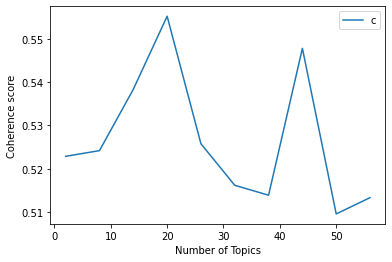

In [ ]:
start,stop,step=2,60,6
plot_graph(clean_text,start,stop,step)

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6653
Num Topics = 8  has Coherence Value of 0.5682
Num Topics = 14  has Coherence Value of 0.5411
Num Topics = 20  has Coherence Value of 0.5392
Num Topics = 26  has Coherence Value of 0.541
Num Topics = 32  has Coherence Value of 0.5416
Num Topics = 38  has Coherence Value of 0.5342


In [ ]:
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)

[(0, '-0.345*"best" + -0.341*"oscar" + -0.312*"pictur" + -0.288*"parasit" + -0.257*"work" + -0.233*"earn" + -0.233*"certainli" + -0.233*"enough" + -0.233*"convent" + -0.233*"ill"'), (1, '0.378*"90" + 0.378*"tough" + 0.378*"might" + 0.378*"first" + 0.378*"viewer" + 0.378*"last" + 0.378*"love" + 0.000*"best" + 0.000*"film" + 0.000*"entertain"'), (2, '-0.390*"film" + -0.372*"entertain" + -0.370*"best" + -0.307*"fairli" + -0.307*"2019" + -0.307*"one" + 0.199*"work" + 0.147*"parasit" + -0.145*"winner" + -0.145*"korean"'), (3, '-0.347*"way" + -0.347*"plan" + -0.347*"life" + -0.347*"make" + -0.347*"never" + -0.331*"work" + -0.211*"film" + 0.206*"oscar" + -0.197*"entertain" + -0.157*"2019"'), (4, '0.392*"oscar" + 0.276*"attent" + 0.276*"topic" + 0.276*"time" + 0.276*"pay" + -0.235*"parasit" + 0.221*"movi" + 0.221*"winner" + 0.221*"korean" + 0.181*"make"'), (5, '-0.300*"drama" + -0.300*"intellig" + -0.300*"engag" + -0.300*"aspect" + -0.300*"social" + 0.286*"superb" + 0.286*"intrigu" + 0.286*"pr

(3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

# Write your answer here (no code needed for this question)
The interpretaion of the topic modelling can be used for testing of topic modelling. In which to attain various types of topic models we use various types of methods which are Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA) are  two methods of LDA (Leadership Development Agency).

In this model the dictionery and corpus are the important inputs where each word in the text is given an unique id by using genism module

The module also comprises of many other topic in addition two this key inputs(i.e. dictionery and corpus)
By testing with a limited number of topics  and compare results by using the LDA visualization tool pyLDAvis.

The topic coherence is knows as the popular strategies for estimating number of topics. By constructing a number of LDA models with varied numbers of topics (k) and through selecting the one with the highest coherence value. Choosing a ‘k' that denotes the end of a rapid increase in subject coherence normally yields topics that are relevant and comprehensible.

In the plot it shows if coherence decreases then number of topic decreases and vice versa

At the score of 10 the optimal topics are observed, also LDA algorithm has a coherence value of 0.62

LSA (Local Self-Assessment) is used for noise reduction and diamension reduction technique

In topic modeling to calucluate the K(number of topics) we have to use
topic coherence test

A topic model which consist of high coherence score will be considered

The optimum coherence score is recorded as 0.52 with topic at 6. For the plot, i.e., coherence value and number of topics using LSA algorithm, the optimum coherence score is observed at 0.52 with topic at 6.

As a consequence of the study, LDA outperforms LSA.
